<a href="https://colab.research.google.com/github/encoras/Artificial-Intelligence-Group/blob/master/Feature_selection_using_Boruta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Feature selection using Boruta**

In [10]:
# Code is adopted from the video
# https://youtu.be/_5t8ZtRybT8


import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.metrics import accuracy_score
RAND=123

In [2]:
# import some data to play with
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data

Y = breast_cancer.target
feature_names=breast_cancer.feature_names

In [3]:
#Define x and normalize values

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

##Split data into train and test to verify accuracy after fitting the model.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=RAND)

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
###########################################################################

Create shadow features – random features and shuffle values in columns
Train Random Forest and calculate feature importance via mean decrease impurity
Check if real features have higher importance compared to shadow features
Repeat this for every iteration
If original feature performed better, then mark it as important

In [4]:
#Install Boruta for first time
!pip install boruta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.2 MB/s eta 0:00:00


In [5]:
# Define RandomForest classifier to be used by Boruta
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(random_state=RAND)
rfr.fit(X_train, y_train)
y_pred=rfr.predict(X_test)>0.5
scores_RFR=accuracy_score(y_test,y_pred)
print('RFR_ALL_features = ', scores_RFR)

RFR_ALL_features =  0.986013986013986


In [6]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=RAND)
rfc.fit(X_train, y_train)
y_pred=rfc.predict(X_test)
scores_RFC=accuracy_score(y_test,y_pred)
print('RFC_ALL_features = ', scores_RFC)

RFC_ALL_features =  0.993006993006993


In [7]:
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier(random_state=RAND)
etc.fit(X_train, y_train)
y_pred=etc.predict(X_test)
scores_ETC=accuracy_score(y_test,y_pred)
print('ETC_ALL_features = ', scores_ETC)

ETC_ALL_features =  0.986013986013986


In [14]:
from boruta import BorutaPy

np.int = np.int32
np.float = np.float64
np.bool = np.bool_

# define Boruta feature selection method: rfr, rfc, etc
feat_selector = BorutaPy(rfr, n_estimators='auto', verbose=1, random_state=RAND) #, max_iter=10

# find all relevant features
feat_selector.fit(X_train, y_train)


# check selected features
print(feat_selector.support_)  #Should we accept the feature

# check ranking of features
print(feat_selector.ranking_) #Rank 1 is the best

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100
Iteration: 35 / 100
Iteration: 36 / 100
Iteration: 37 / 100
Iteration: 38 / 100
Iteration: 39 / 100
Iteration: 40 / 100
Iteration: 41 / 100
Iteration: 42 / 100
Iteration: 43 / 100
Iteration: 44 / 100
Iteration: 45 / 100
Iteration: 46 / 100
Iteration: 47 / 100
Iteration: 48 / 100
Iteration: 49 / 100
Iteration: 50 / 100
Iteration

In [15]:
# call transform() on X to filter it down to selected features
X_train_filtered = feat_selector.transform(X_train)  #Apply feature selection and return transformed data
X_test_filtered = feat_selector.transform(X_test)
"""
Review the features
"""
# zip feature names, ranks, and decisions
feature_ranks = list(zip(feature_names,
                         feat_selector.ranking_,
                         feat_selector.support_))

# print the results
for feat in feature_ranks:
    print('Feature: {:<30} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))

Feature: mean radius                    Rank: 14,  Keep: False
Feature: mean texture                   Rank: 1,  Keep: True
Feature: mean perimeter                 Rank: 15,  Keep: False
Feature: mean area                      Rank: 2,  Keep: False
Feature: mean smoothness                Rank: 11,  Keep: False
Feature: mean compactness               Rank: 21,  Keep: False
Feature: mean concavity                 Rank: 3,  Keep: False
Feature: mean concave points            Rank: 1,  Keep: True
Feature: mean symmetry                  Rank: 20,  Keep: False
Feature: mean fractal dimension         Rank: 19,  Keep: False
Feature: radius error                   Rank: 7,  Keep: False
Feature: texture error                  Rank: 7,  Keep: False
Feature: perimeter error                Rank: 9,  Keep: False
Feature: area error                     Rank: 1,  Keep: True
Feature: smoothness error               Rank: 11,  Keep: False
Feature: compactness error              Rank: 18,  Keep: False
Fea

**Now use the subset of features to fit  model on training data**

RFR_ALL_features =  0.986013986013986  vs RFR_filtered =  0.986013986013986 Is better?  False
RFC_ALL_features =  0.993006993006993  vs RFC_filtered =  0.993006993006993 Is better?  False
ETC_ALL_features =  0.986013986013986  vs ETC_filtered =  0.986013986013986 Is better?  False


<Axes: >

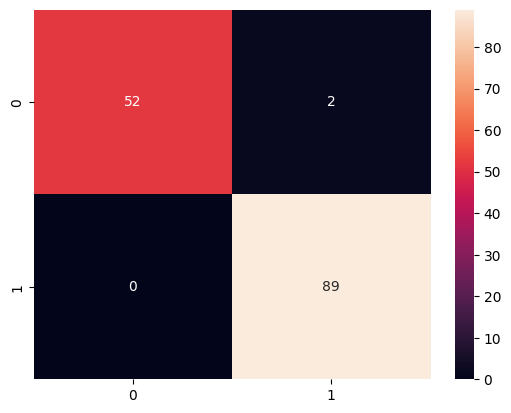

In [16]:
rfr.fit(X_train_filtered, y_train)
y_pred=rfr.predict(X_test_filtered)>0.5
scores_RFR1=accuracy_score(y_test,y_pred)
print('RFR_ALL_features = ', scores_RFR, ' vs RFR_filtered = ', scores_RFR1, 'Is better? ', scores_RFR<scores_RFR1)
#######################################

rfc.fit(X_train_filtered, y_train)
y_pred=rfc.predict(X_test_filtered)
scores_RFC1=accuracy_score(y_test,y_pred)
print('RFC_ALL_features = ', scores_RFC, ' vs RFC_filtered = ', scores_RFC1, 'Is better? ', scores_RFC<scores_RFC1)
#######################################

etc.fit(X_train_filtered, y_train)
y_pred=etc.predict(X_test_filtered)
scores_ETC1=accuracy_score(y_test,y_pred)
print('ETC_ALL_features = ', scores_ETC, ' vs ETC_filtered = ', scores_ETC1, 'Is better? ', scores_ETC<scores_ETC1)

#Print overall accuracy


#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
#print(cm)
sns.heatmap(cm, annot=True)

#######################################################




